In [31]:
import warnings
warnings.filterwarnings("ignore")
import bo_wrangle as wra
import wrangle as w
import functions as f

import pandas as pd
import numpy as np

#splits
from sklearn.model_selection import train_test_split

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#statistical
from scipy.stats import chi2_contingency

#scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, classification_report

#model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

# Acquire

In [2]:
merged_data = w.left_join_csv('austin_animal_outcomes.csv', 'austin_animal_intakes.csv', 'merged_data.csv')

In [3]:
df = merged_data

# Prepare

In [4]:
df, model_df = w.prep_df(df)

In [5]:
df.head(5) 

,dob,outcome,sex,name,intake_type,condition,species,breed,outcome_age,rel_month,rel_year,primary_color,is_tabby,mix_color
0,2017-05-02,adoption,neutered male,1,owner surrender,normal,cat,mix,736,may,2019,brown,1,1
1,2017-07-12,adoption,neutered male,1,stray,normal,dog,mix,371,jul,2018,white,0,1
5,2014-03-12,transfer,intact male,1,stray,medical attention,cat,mix,6,mar,2014,orange,1,0
8,2018-03-01,adoption,neutered male,1,owner surrender,normal,dog,two breeds,797,may,2020,white,0,1
9,2022-05-04,adoption,neutered male,1,stray,normal,cat,mix,76,jul,2022,brown,1,0


In [6]:
# Save the DataFrame as a JSON file
df.to_json('super_clean.json', orient='records')

In [7]:
model_df.head()

,outcome,name,is_tabby,mix_color,sex_intact male,sex_neutered male,sex_spayed female,intake_type_euthanasia request,intake_type_owner surrender,intake_type_public assist,...,primary_color_gray,primary_color_lilac point,primary_color_lynx point,primary_color_orange,primary_color_red,primary_color_sable,primary_color_seal point,primary_color_tan,primary_color_tricolor,primary_color_white
0,adoption,1,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,adoption,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,transfer,1,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,adoption,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
9,adoption,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.shape

(110079, 14)

In [9]:
model_df.shape

(110079, 34)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110079 entries, 0 to 197201
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   dob            110079 non-null  datetime64[ns]
 1   outcome        110079 non-null  object        
 2   sex            110079 non-null  object        
 3   name           110079 non-null  int64         
 4   intake_type    110079 non-null  object        
 5   condition      110079 non-null  object        
 6   species        110079 non-null  object        
 7   breed          110079 non-null  object        
 8   outcome_age    110079 non-null  int64         
 9   rel_month      110079 non-null  object        
 10  rel_year       110079 non-null  object        
 11  primary_color  110079 non-null  object        
 12  is_tabby       110079 non-null  int64         
 13  mix_color      110079 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(9)
memory usa

In [11]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110079 entries, 0 to 197201
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   outcome                         110079 non-null  object
 1   name                            110079 non-null  int64 
 2   is_tabby                        110079 non-null  int64 
 3   mix_color                       110079 non-null  int64 
 4   sex_intact male                 110079 non-null  uint8 
 5   sex_neutered male               110079 non-null  uint8 
 6   sex_spayed female               110079 non-null  uint8 
 7   intake_type_euthanasia request  110079 non-null  uint8 
 8   intake_type_owner surrender     110079 non-null  uint8 
 9   intake_type_public assist       110079 non-null  uint8 
 10  intake_type_stray               110079 non-null  uint8 
 11  condition_injured               110079 non-null  uint8 
 12  condition_medical attention   

In [12]:
train, validate, test = w.split_data(df, "outcome")

train -> (66047, 14), 60.0%
validate -> (22016, 14),20.0%
test -> (22016, 14), 20.0%


# Question and Hypothesis Statement

## Does breed affect whether an animal will be adopted?

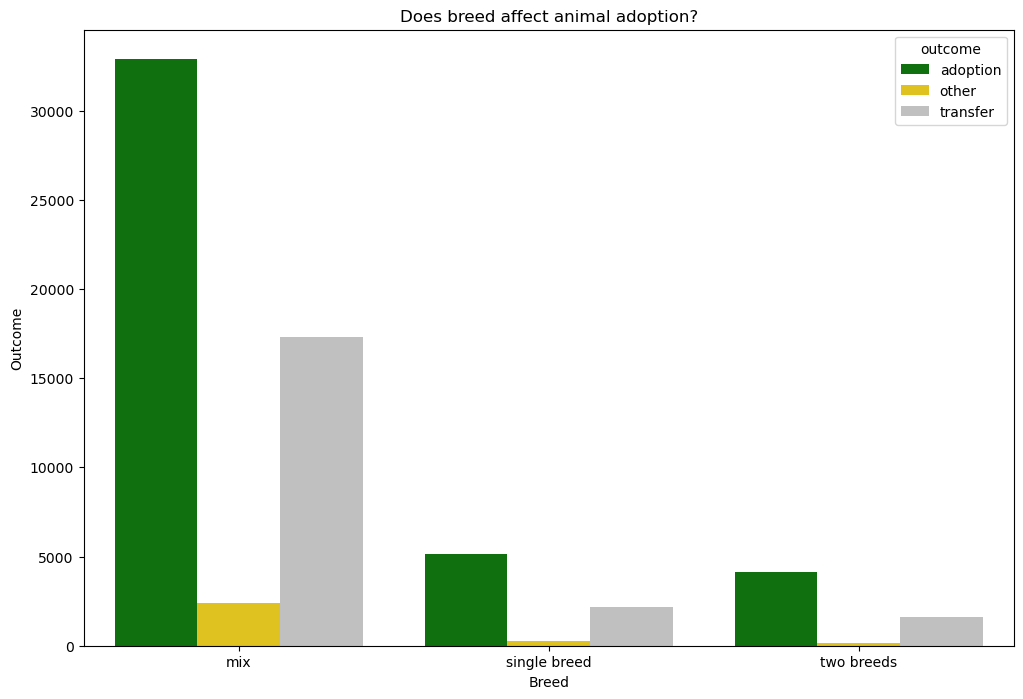

In [13]:
# visualize relationship breed affect adoption
plt.figure(figsize=(12,8))
sns.countplot(x='breed', hue='outcome', data=train, palette=['green', 'gold', 'silver'])
plt.title('Does breed affect animal adoption?')
plt.xlabel('Breed')
plt.ylabel('Outcome')
plt.show()

* Looking at the three breed types there may be some indication that there might be a slight indication of no relationship.
* The chi-squared test of independence tests the null hypothesis that there is no relationship between the two variables (breed and outcome) in the population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant relationship between the two variables.
* $H0$ = There is no relationship between breed and outcome.
* $Ha$ = There is a relationship between breed and outcome.

In [14]:
# Create a contingency table of breed and outcome
contingency_table = pd.crosstab(train['breed'], train['outcome'])

# Perform a chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results of the chi-squared test
print('Chi-squared statistic:', chi2)
print('p-value:', p)

Chi-squared statistic: 254.21904352195457
p-value: 8.028187589209715e-54


## Findings
* There is a higher volume of mixed breeds that are not adopted or transfered
* The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
* The p-value is extremely small, indicating strong evidence to reject the null hypothesis
* Recommendation: Send forward to modeling

## Does intake type affect whether an animal will be adopted?

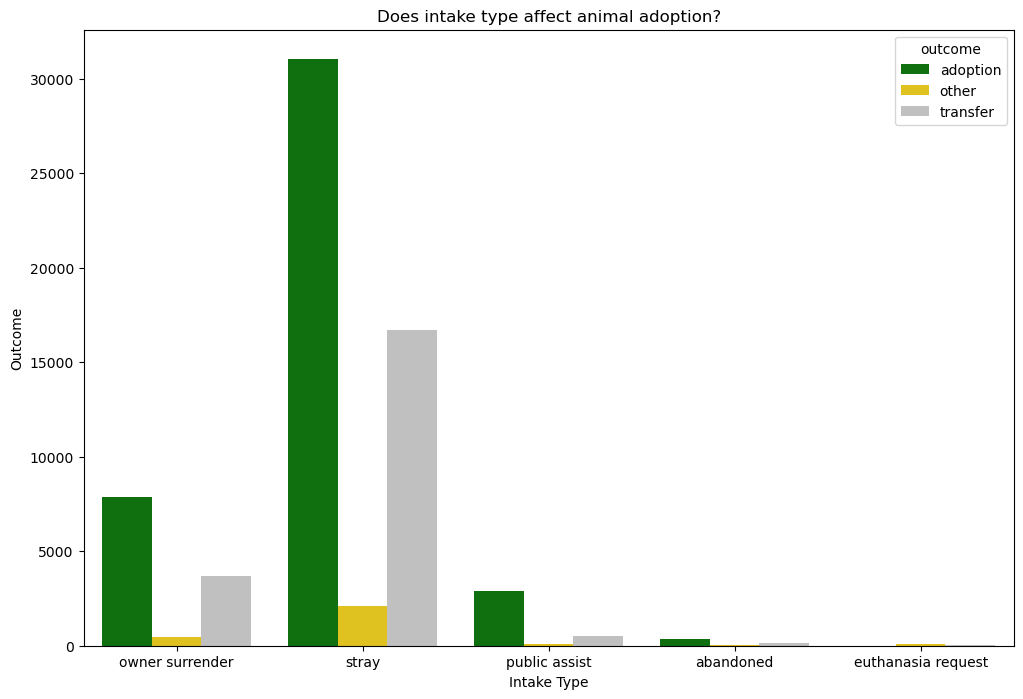

In [15]:
# visualize relationship breed affect adoption
plt.figure(figsize=(12,8))
sns.countplot(x='intake_type', hue='outcome', data=train, palette=['green', 'gold', 'silver'])
plt.title('Does intake type affect animal adoption?')
plt.xlabel('Intake Type')
plt.ylabel('Outcome')
plt.show()

* Looking at the five intake types there may be some indication of a relationship.
* The chi-squared test of independence tests the null hypothesis that there is no relationship between the two variables (intake_type and outcome) in the population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant relationship between the two variables.
* $H0$ = There is no relationship between intake type and outcome.
* $Ha$ = There is a relationship between intake type and outcome.

In [16]:
# Create a contingency table of breed and outcome
contingency_table = pd.crosstab(train['intake_type'], train['outcome'])

# Perform a chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results of the chi-squared test
print('Chi-squared statistic:', chi2)
print('p-value:', p)

Chi-squared statistic: 2408.018143837644
p-value: 0.0


## Findings
* There is a higher volume of strays that are not adopted or transfered
* The Chi-squared statistic indicates substantial difference between the observed and expected frequencies
* The p-value is small, indicating strong evidence to reject the null hypothesis
* Recommendation: Send forward to modeling

## Modeling Conclusion

In [17]:
X_train,y_train,X_validate,y_validate,X_test,y_test = f.get_xy()

train -> (66047, 34), 60.0%
validate -> (22016, 34),20.0%
test -> (22016, 34), 20.0%


In [18]:
baseline_df = f.get_baseline(y_train)

In [19]:
baseline_df

,Baseline,Metric,Score
0,"0 adoption Name: outcome, dtype: object",Accuracy,0.638727


## Comparing Models
* Baseline: 63.87
* The KNN Model yielded a train accuracy of 79.08 and a validate accuracy of 78.99
* The Logistics Regression Model yielded a train accuracy of 79.46 and a validate accuracy of 79.60
* The Decision Tree Model yielded a train accuracy of 79.06 and a validate accuracy of 79.18
* The Random Forest Model yielded a train accuracy of 71.23 and a validate accuracy of 71.31
* The Support Vector Machine Model yielded a train accuracy of 79.87 and a validate accuracy of 79.78
* The Naive Bayes Model yielded a train accuracy of 67.73 and a validate accuracy of 67.66
* The Gradient Boosting Model yielded a train accuracy of 79.74 and a validate accuracy of 79.76

## Model Selection
* The Gradient Boosting Model maintained a 79.75 % average accuracy with only a 0.02 differential in both train and validate. While most of the models did well with the exception of the Naive Bayes model, there were slight variances between the train and validate sets. We beat the baseline accuracy score of 63.87% by 15.88% when using the average of the Gradient Boosting Model. We will move forward with the Gradient Boosting Model using the final test data set.

In [21]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

# Create the gradient boosting classifier
gbm = GradientBoostingClassifier()

# Create the grid search object
grid_search = GridSearchCV(gbm, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the training set
train_accuracy = best_model.score(X_train, y_train)
print("Training Accuracy: ", train_accuracy)

# Evaluate the best model on the validation set
validation_accuracy = best_model.score(X_validate, y_validate)
print("Validation Accuracy: ", validation_accuracy)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best Score:  0.7973564843413888
Training Accuracy:  0.799052190107045
Validation Accuracy:  0.7977834302325582


In [22]:
# Define the parameter grid for grid search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10]
}

# Create the logistic regression classifier
lr = LogisticRegression()

# Create the grid search object
grid_search = GridSearchCV(lr, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the training set
train_accuracy = best_model.score(X_train, y_train)
print("Training Accuracy: ", train_accuracy)

# Evaluate the best model on the validation set
validation_accuracy = best_model.score(X_validate, y_validate)
print("Validation Accuracy: ", validation_accuracy)

Best Parameters:  {'C': 10, 'penalty': 'l2'}
Best Score:  0.7946462821067621
Training Accuracy:  0.7946159553045559
Validation Accuracy:  0.7959665697674418


In [24]:
# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create the SVM classifier
svm = SVC()

# Create the grid search object
grid_search = GridSearchCV(svm, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the training set
train_accuracy = best_model.score(X_train, y_train)
print("Training Accuracy: ", train_accuracy)

# Evaluate the best model on the validation set
validation_accuracy = best_model.score(X_validate, y_validate)
print("Validation Accuracy: ", validation_accuracy)

KeyboardInterrupt: 

In [25]:
# Initialize the gradient boosting classifier
gb_model = GradientBoostingClassifier()

# Fit the model on the training data
gb_model.fit(X_train, y_train)

# Make predictions on the training data
y_pred_train = gb_model.predict(X_train)

# Evaluate the accuracy of the model on the training data
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", accuracy_train)

# Make predictions on the validation data
y_pred = gb_model.predict(X_validate)

# Evaluate the accuracy of the model on the validation data
accuracy = accuracy_score(y_validate, y_pred)
print("Validation Accuracy:", accuracy)

# Make predictions on the test data
y_pred_test = gb_model.predict(X_test)

Train Accuracy: 0.7974321316638152
Validation Accuracy: 0.7975563226744186


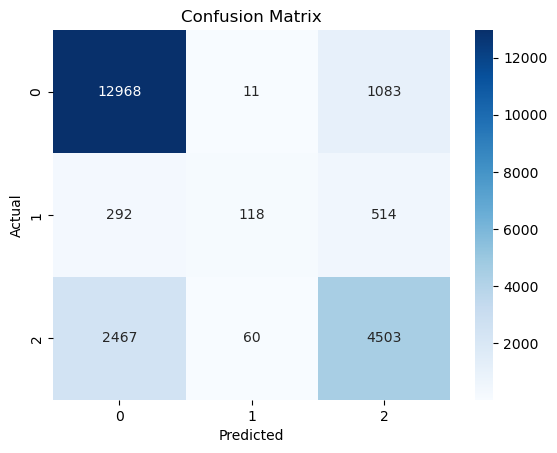

In [27]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

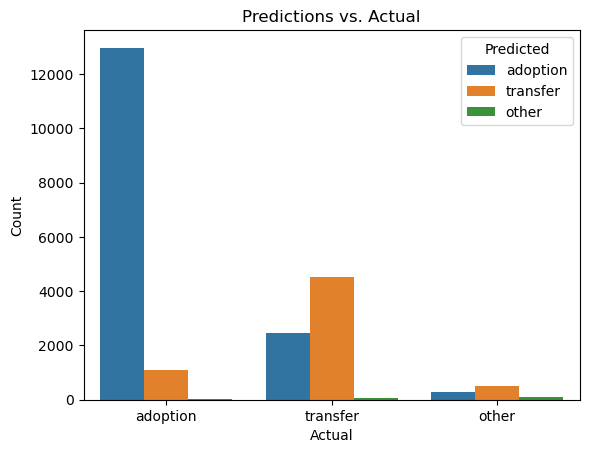

In [28]:
# Create a dataframe with the actual and predicted labels
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})

# Create a count plot
sns.countplot(data=df, x='Actual', hue='Predicted')
plt.xlabel('Actual')
plt.ylabel('Count')
plt.title('Predictions vs. Actual')
plt.show()

In [32]:
# Initialize the AdaBoost classifier
ada_model = AdaBoostClassifier()

# Fit the model on the training data
ada_model.fit(X_train, y_train)

# Make predictions on the validation data
y_pred = ada_model.predict(X_validate)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_validate, y_pred)
print("Validation Accuracy:", accuracy)

# Make predictions on the test data
y_pred_test = ada_model.predict(X_test)

# Evaluate the accuracy of the model on the test data
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

Validation Accuracy: 0.7951944040697675
Test Accuracy: 0.7956031976744186


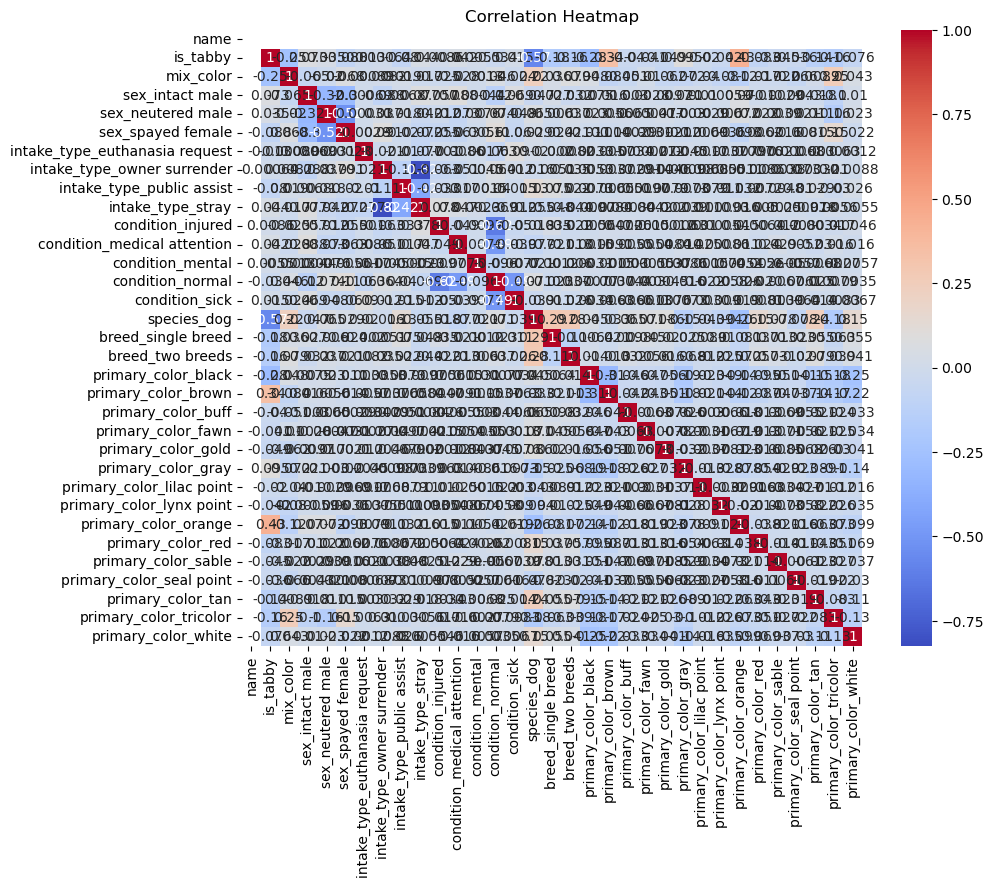

In [33]:
# Concatenate the training and validation data
X = pd.concat([X_train, X_validate])

# Perform one-hot encoding on the concatenated data
X_encoded = pd.get_dummies(X)

# Calculate the correlation matrix
correlation_matrix = X_encoded.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True)
plt.title("Correlation Heatmap")
plt.show()

# Question and Hypothesis Statement

# Conclusion

# Question and Hypothesis Statement

# Conclusion